/home/vscode/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


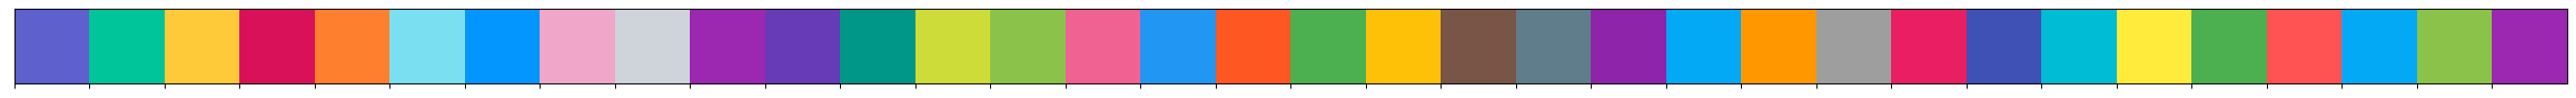

In [1]:
from sklearn import preprocessing
from base import *
from umap_func import *
import json
import matplotlib
# matplotlib font setting for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
skip = True
# skip = False
if not skip:
    before, after = 20, 30
    dir = "data_qm/"
    all_cut_data = np.empty((0, 50))
    all_key = 0
    all_temp_info = {}

    for folder in os.listdir(dir):
        if folder.endswith("_cleaned"):
            file_name = folder.replace("_cleaned", "cbt")
            cleaned_zip = []
            for qm in os.listdir(os.path.join(dir, folder)):
                cleaned_zip.append(qm)
            cleaned_zip.sort()
            print(cleaned_zip)
            cut_data = np.empty((0, 50))
            temp_info = {}
            key = 0   # this is the shared index to the template and temp_info 
            for qm in cleaned_zip:
                trains, neuron_data, config, _ = load_curation(os.path.join(dir, folder, qm))
                rec_length = np.max([np.max(t) for t in trains])
                print(f"recording length: {rec_length}")
                for k, v in neuron_data.items():
                    d = v["template"]
                    if abs(np.min(d)) > abs(np.max(d)):  # this is a negative spike
                        peak_index = np.argmin(d)
                    else:
                        peak_index = np.argmax(d)  # this is a positive spike
                    if peak_index >= before and peak_index < 100-after:
                        # save the cut template
                        new_spike = d[peak_index-before: peak_index+after]
                        cut_data = np.vstack((cut_data, new_spike))
                        all_cut_data = np.vstack((all_cut_data, new_spike))
                        # also save the dataset name and the location of the spike
                        # save these to another file but keep the indexing the same
                        temp_info[key] = {"dataset": qm, 
                                            "index": int(k),
                                            "cluster_id":int(v["cluster_id"]),
                                            "channel": int(v["channel"]),
                                            "location": list(v["position"]),
                                            "train": list(trains[k]),
                                            "rec_length": rec_length
                                            }
                        all_temp_info[all_key] = {"dataset": qm,
                                                "index": int(k),
                                                "cluster_id":int(v["cluster_id"]),
                                                "channel": int(v["channel"]),
                                                "location": list(v["position"]),
                                                "train": list(trains[k]),
                                                "rec_length": rec_length
                                                }
                        key += 1
                        all_key += 1
            print(cut_data.shape)
            np.save(f"clean_template_npy/{file_name}_cut.npy", cut_data)
            with open(f"clean_template_npy/{file_name}_info.json", "w") as f:
                json.dump(temp_info, f, indent=4)
            print(f"Saving {file_name} Done")
    print(all_cut_data.shape)
    np.save(f"clean_template_npy/all_neurons/all_cut.npy", all_cut_data)
    with open(f"clean_template_npy/all_neurons/all_info.json", "w") as f:
        json.dump(all_temp_info, f, indent=4)
    print("Save all Done")

In [3]:
# exclude slice "hc9.19_chp-16849_plated-10.19.22_rec10.19.22" and "hc11.1_plated-11.1_chip-16753_rec_11.2.22AM"
# load all_cut and all_info, remove the spikes from the two slices and save to new files
# also save the removed spikes to a separate file
if not skip:
    all_neurons = np.load(f"clean_template_npy/all_neurons/all_cut.npy", allow_pickle=True)
    with open("clean_template_npy/all_neurons/all_info.json", "r") as f:
        all_temp_info = json.load(f)

    exclude = ["hc9.19_chp-16849_plated-10.19.22_rec10.19.22", "hc11.1_plated-11.1_chip-16753_rec_11.2.22AM"]
    new_cut = np.empty((0, 50))
    new_info = {}
    remove_cut = np.empty((0, 50))
    remove_info = {}
    key = 0
    remove_key = 0
    for sk, v in all_temp_info.items():
        k = int(sk)
        for e in exclude:
            if e in v["dataset"]:
                remove_cut = np.vstack((remove_cut, all_neurons[k]))
                remove_info[remove_key] = v
                remove_key += 1
                break
        else:   
            new_cut = np.vstack((new_cut, all_neurons[k]))
            new_info[key] = v
            key += 1
    print(new_cut.shape, remove_cut.shape)
    np.save(f"clean_template_npy/all_neurons/new_cut.npy", new_cut)
    with open(f"clean_template_npy/all_neurons/new_info.json", "w") as f:
        json.dump(new_info, f, indent=4)
    np.save(f"clean_template_npy/all_neurons/remove_cut.npy", remove_cut)
    with open(f"clean_template_npy/all_neurons/remove_info.json", "w") as f:
        json.dump(remove_info, f, indent=4)
    print("Done")

shape of all of the neurons waveforms: (3681, 50)
276
[11, 11, 0, 0, 11, 3, 4, 0, 0, 0, 6, 3, 3, 4, 3, 0, 0, 6, 0, 0, 0, 3, 0, 8, 11, 3, 3, 3, 4, 3, 0, 11, 0, 0, 3, 2, 4, 4, 3, 3, 5, 8, 4, 5, 5, 4, 2, 4, 5, 4, 3, 3, 5, 3, 4, 5, 4, 4, 5, 9, 4, 4, 3, 4, 3, 4, 3, 0, 6, 7, 0, 0, 0, 6, 4, 7, 7, 0, 11, 4, 0, 4, 3, 5, 3, 4, 0, 6, 0, 8, 6, 7, 7, 4, 3, 5, 7, 3, 6, 3, 4, 3, 4, 3, 3, 6, 8, 4, 8, 4, 5, 3, 8, 7, 7, 7, 4, 9, 11, 5, 11, 3, 11, 7, 4, 9, 3, 7, 8, 6, 5, 4, 6, 11, 5, 5, 9, 0, 9, 4, 4, 9, 8, 6, 7, 0, 4, 11, 7, 2, 2, 3, 7, 7, 5, 7, 4, 4, 7, 4, 9, 8, 4, 4, 6, 6, 4, 11, 0, 0, 5, 6, 7, 4, 0, 3, 3, 3, 7, 0, 2, 8, 6, 9, 3, 7, 7, 3, 3, 9, 8, 11, 5, 0, 4, 4, 6, 11, 4, 6, 8, 7, 4, 7, 4, 6, 4, 7, 5, 5, 6, 4, 11, 3, 4, 4, 9, 7, 5, 3, 0, 6, 6, 5, 3, 0, 0, 5, 4, 8, 6, 4, 4, 8, 8, 4, 9, 0, 4, 4, 4, 4, 7, 4, 6, 3, 4, 7, 3, 4, 9, 11, 4, 0, 5, 4, 5, 4, 4, 9, 4, 5, 7, 4, 2, 3, 0, 4, 4, 4, 4, 11, 5, 4, 0, 0, 4, 5, 7, 5, 7, 4, 4, 0, 9, 3, 3, 7, 4, 7, 0, 3, 3, 8, 3, 5, 3, 9, 4, 8, 9, 4, 0, 9, 7, 6, 5, 6, 3, 3

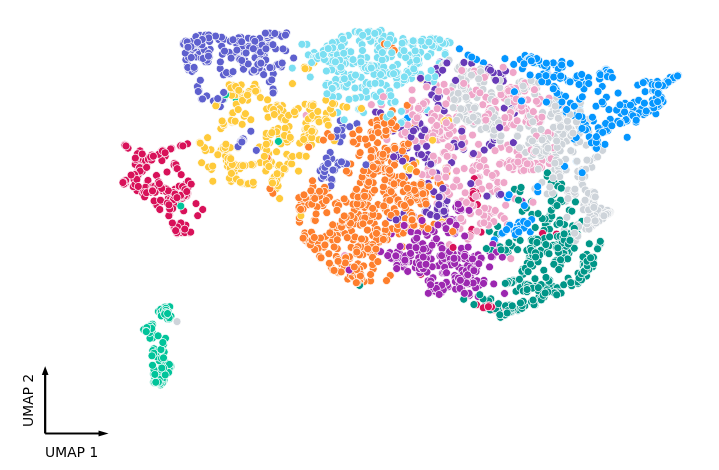

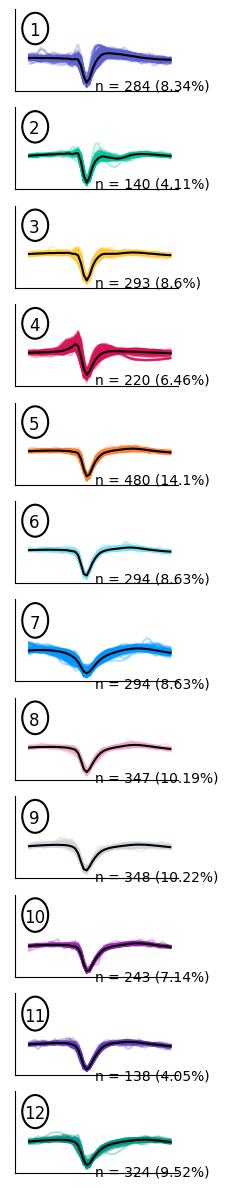

In [4]:
# Let's make the uamp for all of the neruons
# then check where they come from 
plot_each = False
all_neurons = np.load(f"clean_template_npy/all_neurons/new_cut.npy", allow_pickle=True)
figure_name = f"neurons_2023_cut_norm_exclude"
all_neurons = preprocessing.normalize(all_neurons, norm='l2')
print(f"shape of all of the neurons waveforms: {all_neurons.shape}")
if plot_each:
    # plot individual neurons,remove the ones that don't look good
    for i in range(len(all_neurons)):
        spike = all_neurons[i]
        fig, axs = plt.subplots(1, 1, figsize=(3, 2), tight_layout=True)
        axs.plot(spike, label=f"{i}")
        axs.legend()
        plt.savefig(f"all_neuron_waveforms/{i}.png", dpi=300)
        plt.close()

# remove the positive spikes for now because they are possibly from the axon
bad_spike_index = [5, 12, 19, 24, 38, 40, 42, 53, 54, 78, 79, 81, 82, 95, 125, 135, 
                   141, 146, 210, 230, 232, 241, 261, 269, 277, 289, 298, 315, 330, 
                   338, 340, 341, 342, 344, 345, 356, 360, 365, 371, 372, 373, 375, 
                   376, 377, 379, 380, 381, 382, 388, 389, 390, 395, 397, 399, 400, 
                   402, 403, 411, 413, 414, 415, 419, 430, 433, 438, 448, 451, 453, 
                   455, 459, 462, 465, 466, 468, 473, 478, 480, 481, 487, 494, 504, 
                   508, 510, 512, 524, 539, 542, 543, 544, 548, 553, 560, 576, 580, 
                   589, 595, 683, 684, 693, 727, 730, 744, 754, 769, 780, 807, 810, 
                   820, 832, 844, 871, 884, 923, 941, 962, 969, 980, 1007, 1054, 1073, 
                   1077, 1086, 1149, 1163, 1168, 1173, 1190, 1191, 1193, 1194, 1197, 
                   1205, 1211, 1220, 1221, 1225, 1228, 1247, 1262, 1265, 1285, 1296, 
                   1304, 1307, 1309, 1311, 1323, 1324, 1326, 1328, 1330, 1348, 1358, 
                   1373, 1376, 1408, 1409, 1466, 1467, 1623, 1624, 1639, 1698, 1724, 
                   1727, 1729, 1730, 1731, 1749, 1778, 1779, 1818, 1850, 1962, 1965, 
                   1989, 2064, 2082, 2160, 2188, 2206, 2212, 2217, 2252, 2257, 2273, 
                   2287, 2288, 2306, 2321, 2355, 2361, 2367, 2399, 2400, 2401, 2421, 
                   2525, 2592, 2621, 2644, 2699, 2746, 2755, 2768, 2814, 2828, 2885, 
                   3007, 3108, 3111, 3120, 3210, 3211, 3217, 3233, 3238, 3247, 3252, 
                   3285, 3287, 3292, 3294, 3320, 3349, 3364, 3371, 3390, 3406, 3499, 
                   3501, 3502, 3509, 3510, 3522, 3527, 3535, 3539, 3540, 3544, 3547, 
                   3548, 3549, 3551, 3553, 3555, 3557, 3567, 3574, 3577, 3578, 3580, 
                   3584, 3598, 3599, 3606, 3610, 3612, 3617, 3623, 3627, 3632, 3634, 
                   3635, 3643, 3648, 3653, 3655, 3657, 3660, 3661, 3664, 3667, 3673, 3678, 3680]
print(len(bad_spike_index))
all_neurons = np.delete(all_neurons, bad_spike_index, axis=0)
        
clustering_solution, umap_df = plot_umap(full_data=all_neurons, 
                                         figure_name=figure_name, 
                                         save_to="clean_template_npy/all_neurons/")
print(clustering_solution)
ALLclass = list(np.arange(len(set(clustering_solution))) + 1)
# ALLclass = [1, 2]
print(ALLclass, len(ALLclass))
fig, axs = plt.subplots(len(ALLclass), 1, figsize=(3*0.7, 1.8*0.7*len(ALLclass)))
for ci in ALLclass: # BSclass:
    ind = ALLclass.index(ci)
    arr = plot_group(ci, clustering_solution, umap_df, CUSTOM_PAL_SORT_3, arr=axs[ind])
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_clusters.png", dpi=300)
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_clusters.pdf", dpi=300)

In [5]:
# save bad_spike_index to npy
skip_save = True
if not skip_save:
    np.save(f"clean_template_npy/all_neurons/new_bad_spike_index.npy", bad_spike_index)

In [6]:
# find the bad spikes aftter the first plot, remove them and plot again
find_bad_spikes = False
if find_bad_spikes:
    bad_spike_index = []
    for i in range(len(umap_df)):
        if umap_df["color"][i] in [9]:   # color is the cluster number -1
            bad_spike_index.append(i)
            # fig, axs = plt.subplots(1, 1, figsize=(3, 2), tight_layout=True)
            # axs.plot(umap_df["waveform"][i], label=f"{i}")
            # axs.legend()
    print(bad_spike_index)
# elif len(bad_spike_index) == 0:
    # bad_spike_index = []

In [7]:
# We calculate the modularity score and number of 
# Louvain clusters across a range of resolution parameters 
# while randomly permuting the waveform order.
skip_modularity = True
if not skip_modularity:
    resolution_list = np.linspace(0,10,21)
    modularity_dict = {}
    n_clusts_dict = {}

    subsets=[80]

    for res in resolution_list:
        print("\n" + BlueCol + str(res))
        for frac in subsets:
            rand_list = []
            n_clusts = []
            for i in list(range(1,25)):
                reducer_rand_test = umap.UMAP(n_neighbors = N_NEIGHBORS, 
                                        min_dist=MIN_DIST, 
                                        random_state=random.randint(1,100000))
                rand_data = np.random.permutation(all_neurons)[0:(int(len(all_neurons)*frac)),:]
                mapper = reducer_rand_test.fit(rand_data)
                embedding_rand_test = reducer_rand_test.transform(rand_data)

                umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
                G = nx.from_scipy_sparse_matrix(mapper.graph_)
                clustering = cylouvain.best_partition(G, resolution = res)
                modularity = cylouvain.modularity(clustering, G)
                clustering_solution = list(clustering.values())
                rand_list.append(modularity)
                n_clusts.append(len(set(clustering_solution)))
            modularity_dict.update({str(res): rand_list})
            n_clusts_dict.update({str(res): n_clusts})
            
    # save these dictionaries to a file because it takes a long time to run
    with open('clean_template_npy/all_neurons/modularity_dict.json', 'w') as fp:
        json.dump(modularity_dict, fp, indent=4)
    with open('clean_template_npy/all_neurons/n_clusts_dict.json', 'w') as fp:
        json.dump(n_clusts_dict, fp, indent=4)

In [8]:
if not skip_modularity:
  # and plot both on the same axis
  resolution_list = np.linspace(0,10,21)

  if 'n_clusts_dict' not in list(locals().keys()):
    n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

  if 'modularity_dict' not in list(locals().keys()):
    modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

  avg_n_clusts = []
  for k in list(n_clusts_dict.keys()):
      avg_n_clusts.append(np.mean(n_clusts_dict[k]))
      
  std_n_clusts = []
  for k in list(n_clusts_dict.keys()):
      std_n_clusts.append(np.std(n_clusts_dict[k]))
      
  std_modularity = []
  for k in list(modularity_dict.keys()):
      std_modularity.append(np.std(modularity_dict[k]))
      
  avg_modularity = []
  for k in list(modularity_dict.keys()):
      avg_modularity.append(np.mean(modularity_dict[k]))

  f, ax1 = plt.subplots(figsize=[3,2.5])

  ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
              c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
              linewidth=1, markeredgewidth=1)
  ax1.set_ylabel('Modularity Score')
  ax1.set_xlabel('Resolution Parameter',fontsize=12)
  ax1.set_xlim([0,8])
  ax1.set_xticks([0,2,4,6,8])
  ax1.yaxis.label.set_color('#5c95ff')
  ax1.tick_params(axis='y',colors='#5c95ff')
  ax1.set_ylim(0,1.0)
  ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
  # ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_color('#f87575')
  ax1.spines['left'].set_color('#5c95ff')

  ax2 = ax1.twinx()
  ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
              c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
  ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
  # ax2.spines['left'].set_color('b')
  ax2.tick_params(axis='y',colors='#f87575')
  ax2.set_ylim([0,18])
  ax2.set_yticks([0,4,8,12,16]);
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_color('#f87575')
  ax2.spines['left'].set_color('#5c95ff')
  plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_modularity.png", dpi=300)
  plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_modularity.pdf", dpi=300)

In [9]:
# map back the units to the original dataset, use their index
rec_info_index = {}
with open("clean_template_npy/all_neurons/new_info.json", "r") as f:
    all_temp_info = json.load(f)
for i in range(len(all_temp_info)):
    if i not in bad_spike_index:
        rec = all_temp_info[str(i)]["dataset"]
        if rec not in rec_info_index:
            rec_info_index[rec] = [i]
        else:
            rec_info_index[rec].append(i)

In [10]:
print(rec_info_index)

{'Hc120523_aav9hckcr1_chip21774_121123_0_cleaned.zip': [0, 1, 2, 3, 4, 6, 7, 8], 'Hc120523_aav9hckcr1_chip21774_121123_1_cleaned.zip': [9, 10, 11, 13, 14, 15, 16, 17], 'Hc120523_aav9hckcr1_chip21774_121123_2_cleaned.zip': [18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 'Hc120523_aav9hckcr1_chip21774_121123_base_cleaned.zip': [35, 36, 37, 39, 41, 43, 44], 'Hc110723_hckcr1_21841_111323_0_cleaned.zip': [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59], 'Hc110723_hckcr1_21841_111323_1_cleaned.zip': [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], 'Hc110723_hckcr1_21841_111323_2_cleaned.zip': [77, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123], 'Hc110723_hckcr1_21841_111323_3_cleaned.zip': [124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 1

In [11]:
# save rec_info_index to json
with open('clean_template_npy/all_neurons/new_rec_info_index.json', 'w') as fp:
    json.dump(rec_info_index, fp, indent=4)

In [12]:
# save umap_df to csv
umap_df.to_csv("clean_template_npy/all_neurons/new_umap_df.csv")

In [13]:
slice_rec = {}
slice_info_index = {}
dir = "data_qm/"
for folder in os.listdir(dir):
    if folder.endswith("_cleaned"):
        for zip_file in os.listdir(os.path.join(dir, folder)):
            if zip_file.endswith(".zip") and zip_file in rec_info_index:
                slice_rec[zip_file] = folder
                if folder in slice_info_index:
                    slice_info_index[folder] += rec_info_index[zip_file]
                else:
                    slice_info_index[folder] = rec_info_index[zip_file]

In [14]:
# sanity check
slice_info_index

{'2023-12-11-e-Hc120523_aav9hckcr1_chip21774_cleaned': [0,
  1,
  2,
  3,
  4,
  6,
  7,
  8,
  35,
  36,
  37,
  39,
  41,
  43,
  44,
  9,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 '2023-11-13-e-Hc110723_hckcr1_21841_cleaned': [582,
  583,
  584,
  585,
  586,
  587,
  588,
  590,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  55,
  56,
  57,
  58,
  59,
  227,
  228,
  229,
  231,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  2

In [15]:
# sanity check
set(np.diff(np.sort(slice_info_index["2023-11-13-e-Hc110723_hckcr1_21841_cleaned"])))

{1, 2, 3, 4, 5}

#### TODO: To replace the color dot label on the upper right corner, plot histogram for cell types for each electrodes as an inset figure
Cluster firing rate for fast spiking, regular spiking and other units? \
Reference paper: https://www.nature.com/articles/s41586-023-06839-2 \
color the umap by slice, see how slice data cluster together

In [16]:
print(len(all_temp_info), all_neurons.shape[0], len(bad_spike_index))

3681 3405 276


In [17]:
# plot their position on the electrode map. Generate map for each slice
all_color_ids = np.sort(list(set(umap_df["color"])))
index_list = np.arange(len(all_temp_info))
clean_index = [i for i in index_list if i not in bad_spike_index]
print(len(clean_index))
for slice, index in slice_info_index.items():   # index is a list of indices to the original neurons before removing the bad ones
    fig, axs = plt.subplots(1, 1, figsize=(11, 6), tight_layout=True)
    axs.set_title(f"{slice}")
    color_labels = {}
    for i in index:
        pos = all_temp_info[str(i)]["location"]
        cl_ind = clean_index.index(i)
        color = umap_df["color"][cl_ind]   # umap_df is after removing the bad ones and its indices are continuous, so we need a conversion here
        gitter = random.uniform(-17.5, 17.5)
        axs.scatter(pos[0]+gitter, pos[1]+gitter, c=CUSTOM_PAL_SORT_3[color], s=20, alpha=0.6) 
        if color not in color_labels:
            color_labels[color] = 1
        else: 
            color_labels[color] += 1
    # sort color_labels by key
    color_labels = dict(sorted(color_labels.items()))
    total = np.sum(list(color_labels.values()))
    # show legend for color labels 
    # for k, v in color_labels.items():
    #     lb = f"{k+1}: {np.round(v/total, 3)}"
    #     axs.scatter(-5, -5, c=CUSTOM_PAL_SORT_3[k], s=20, alpha=0.6, 
    #                 label=lb, edgecolors='none')
    # instead of using the labels, plot a histogram inset of color_labels 
    axin = axs.inset_axes([3000, 10, 800, 500], transform=axs.transData)
    for k, v in color_labels.items():
        axin.bar(k+1, v/total, color=CUSTOM_PAL_SORT_3[k], alpha=0.6)
        # # show counts on top of the bars
        # axin.text(k, v/total, f"{v}", ha='center', va='bottom', fontsize=8)
    axin.spines['right'].set_visible(False)
    axin.spines['top'].set_visible(False)
    # set the axin x axis tick labels
    axin.set_xticks([0] + list(all_color_ids+1))  
    # axin.set_xticklabels([f"{i+1}" for i in all_color_ids], fontsize=12) # the cluster id is color id +1
    axin.set_xlabel("Waveform Cluster", fontsize=12)
    axin.set_ylabel("Density", fontsize=12)

    # axs.legend(fontsize=12)
    axs.set_xlim(0, 3850)
    axs.set_ylim(0, 2100) 
    axs.invert_yaxis()     
    axs.set_xlabel("x (um)")
    axs.set_ylabel("y (um)")
    # show the key figures only, close the rest
    plt.savefig(f"clean_template_npy/all_neurons/new_{slice}_map.png", dpi=300)
    plt.savefig(f"clean_template_npy/all_neurons/new_{slice}_map.pdf", dpi=300)
    plt.close()

3405


In [18]:
umap_df

,x,y,waveform,color
0,9.429234,5.561916,"[0.04341648137857586, 0.05389632489303594, 0.0...",11
1,9.478931,5.653905,"[0.04856658534208708, 0.060438416292484816, 0....",11
2,0.225073,10.119474,"[0.0076413877539013965, 0.009551734438212578, ...",0
3,1.270367,10.554436,"[0.030157628414058564, 0.02920024324351158, 0....",0
4,9.472432,5.666215,"[0.02430990657300922, 0.04254233701217433, 0.0...",11
...,...,...,...,...
3400,5.662167,4.611990,"[0.03735462874922287, 0.04402509657126332, 0.0...",9
3401,6.251099,8.827670,"[0.04070441069300642, 0.04353602228442061, 0.0...",8
3402,3.523189,10.322666,"[0.033568576963988586, 0.03773212229539875, 0....",5
3403,6.622393,8.906881,"[0.03585628085792772, 0.048812751111314535, 0....",8


In [19]:
pos = umap_df.iloc[0]
print(pos)

x                                                    9.429234
y                                                    5.561916
waveform    [0.04341648137857586, 0.05389632489303594, 0.0...
color                                                      11
Name: 0, dtype: object


In [20]:
## color the umap by the slice, turn the other dot to grey
all_slices = list(slice_info_index.keys())
for slice, index_list in slice_info_index.items():
    f, arr = plt.subplots(1, figsize=[7, 4.5], tight_layout={'pad': 0})
    arr.set_title(f"{slice}")
    f.tight_layout()
    arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),
                marker='o', c="grey", s=32, edgecolor="white", alpha=0.2,
                linewidth=0.5)
    for i in index_list:
        cl_ind = clean_index.index(i)
        pos = umap_df.iloc[cl_ind]
        arr.scatter(pos["x"], pos["y"], c=CUSTOM_PAL_SORT_3[pos["color"]], 
                    s=32, edgecolor="white", alpha=1, linewidth=0.5)
    
    arr.spines['top'].set_visible(False)
    arr.spines['bottom'].set_visible(False)
    arr.spines['left'].set_visible(False)
    arr.spines['right'].set_visible(False)
    arr.set_xticks([])
    arr.set_yticks([])
    # arr.set_xlim(-4, 12)
    # arr.set_ylim(0, 12)

    arr.arrow(-3, 0.8, 0, 1.5, width=0.05, shape="full", ec="none", fc="black")
    arr.arrow(-3, 0.8, 1.2, 0, width=0.05, shape="full", ec="none", fc="black")

    arr.text(-3, 0.3, "UMAP 1", va="center")
    arr.text(-3.5, 1.0, "UMAP 2", rotation=90, ha="left", va="bottom")
    plt.savefig(f"clean_template_npy/all_neurons/new_{slice}_colored_umap.png", dpi=300)
    plt.savefig(f"clean_template_npy/all_neurons/new_{slice}_colored_umap.pdf", dpi=300)
    plt.close()

(3405, 2)


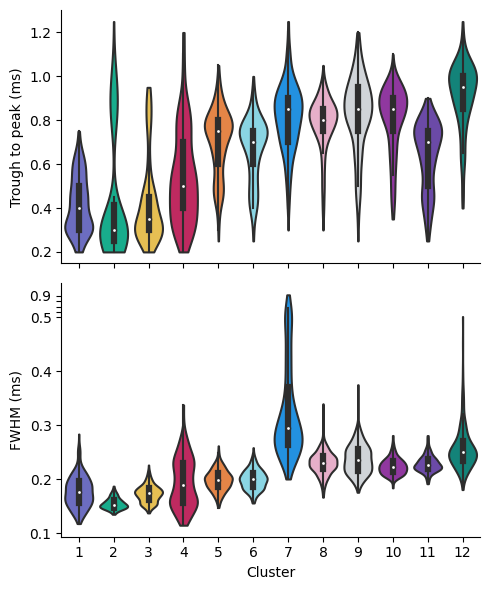

In [21]:
# check out the neuron features and their firing rate
# Define a transformation function -- for ploting outliers in the violin
def transform_y(y, lim=0.5, fct=10):
    if y > lim:
        # Apply scaling for values above 15
        return lim + (y - lim) / fct  # This factor of 10 can be adjusted
    else:
        return y

waveform_values = []
for wf, index in zip(umap_df["waveform"], umap_df["color"]):
    features = waveform_feature(wf)
    values = (features["trough_to_peak"], features["fwhm"])
    waveform_values.append(values)

waveform_values = np.array(waveform_values)
print(waveform_values.shape)
# pair with color
feature_df = pd.DataFrame({"trough_to_peak": waveform_values[:, 0], 
                           "fwhm": waveform_values[:, 1], 
                           "color": umap_df["color"]}).sort_values(by="color")
feature_df["fwhm_transformed"] = feature_df["fwhm"].apply(lambda x: transform_y(x, lim=0.5, fct=10))
unique_color = np.unique(feature_df["color"])
updated_pal = [CUSTOM_PAL_SORT_3[i] for i in unique_color]
# boxplot firing rate by color
fig, axs = plt.subplots(2, 1, figsize=(5, 6), sharex=True, tight_layout=True)
sns.violinplot(x="color", y="trough_to_peak", data=feature_df, cut=0, palette=updated_pal, scale='width', ax=axs[0])
sns.violinplot(x="color", y="fwhm_transformed", data=feature_df, cut=0, palette=updated_pal, scale='width', ax=axs[1])
# hide axs[0] x-axis label
axs[0].set_xlabel("")
axs[0].set_ylabel("Trough to peak (ms)")
axs[1].set_xlabel("Cluster")
axs[1].set_ylabel("FWHM (ms)")
# Adjust y-axis labels to reflect the original scale
y_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Adjust as needed
axs[1].set_yticks([transform_y(y) for y in y_labels])
axs[1].set_yticklabels(y_labels)
# make the y_labels=[0.6, 0.7, 0.8] invisible

yticklabels = axs[1].get_yticklabels()
for y in [0.6, 0.7, 0.8]:
    yticklabels[y_labels.index(y)].set_visible(False)

axs[1].set_xticklabels(np.arange(1, len(unique_color)+1))
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_cbt_feature_boxplot.png", dpi=300)
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_cbt_feature_boxplot.pdf", dpi=300)

Plotting: 3405 Waveforms


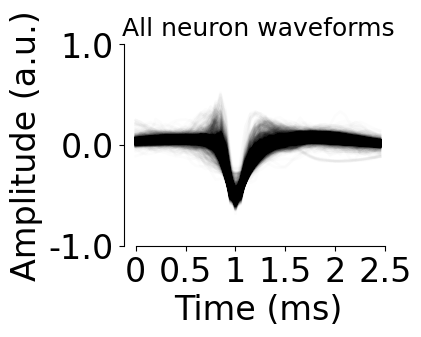

In [22]:
# This plots all the normalized single unit waveforms together. The total waveform length is 100 points at 20000 samples/s
# 25, 50, 75, 100 are the 1.25 ms, 2.5 ms, 3.75 ms, 5 ms time points

# Generate subplots
f, arr = plt.subplots(1, figsize=[4.3, 3.4])

print(BlueCol + "Plotting: " + str(all_neurons.shape[0]) + " Waveforms")
for i in range(0,all_neurons.shape[0]):
    arr.plot(all_neurons[i].T, c = 'k', alpha = 0.01, linewidth=2.)
    
arr.tick_params(direction='out', colors='k', axis='both')
    
# Set various x and y axes and labels etc.
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)

arr.spines['left'].set_bounds(-1, 1)
arr.spines['bottom'].set_bounds(0, 50)

arr.set_xlabel('Time (ms)', fontsize=24)
arr.set_xticks([0, 10, 20, 30, 40, 50])
arr.set_xticklabels(['0','0.5', '1', '1.5', '2', '2.5'], fontsize=24)

arr.set_ylabel('Amplitude (a.u.)', fontsize=24)
arr.set_yticks([-1.0,0.0,1.0])
arr.set_yticklabels([-1.0,0.0,1.0], fontsize=24)

arr.set_title('All neuron waveforms', fontsize=18)

# Plot the data
plt.tight_layout()
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_waveforms_overlay.png", dpi=300)
plt.savefig(f"clean_template_npy/all_neurons/{figure_name}_waveforms_overlay.pdf", dpi=300)
plt.show()


In [ ]:
# save to slice, neuron index and color (cluster index) to csv
